# Blur detection using 2D Discrete Fourier Transform (DFT)
This project investigates the use of the 2D Discrete Fourier Transform (DFT) for the detection of blur in digital images. The 2D DFT transforms an image from the spatial to the frequency domain, unveiling the image's frequency components. Since blurring reduces high-frequency content, the absence of such components in the transformed image indicates blur. By examining the energy spectrum obtained from the DFT, one can quantify the degree of blur. The experiment involved applying the 2D DFT to various images, calculating the high-frequency component ratios, and determining the blurriness of each image. This method's efficacy was validated with sharp and blurred images, demonstrating the 2D DFT's potential as a robust tool for blur detection in image processing applications.

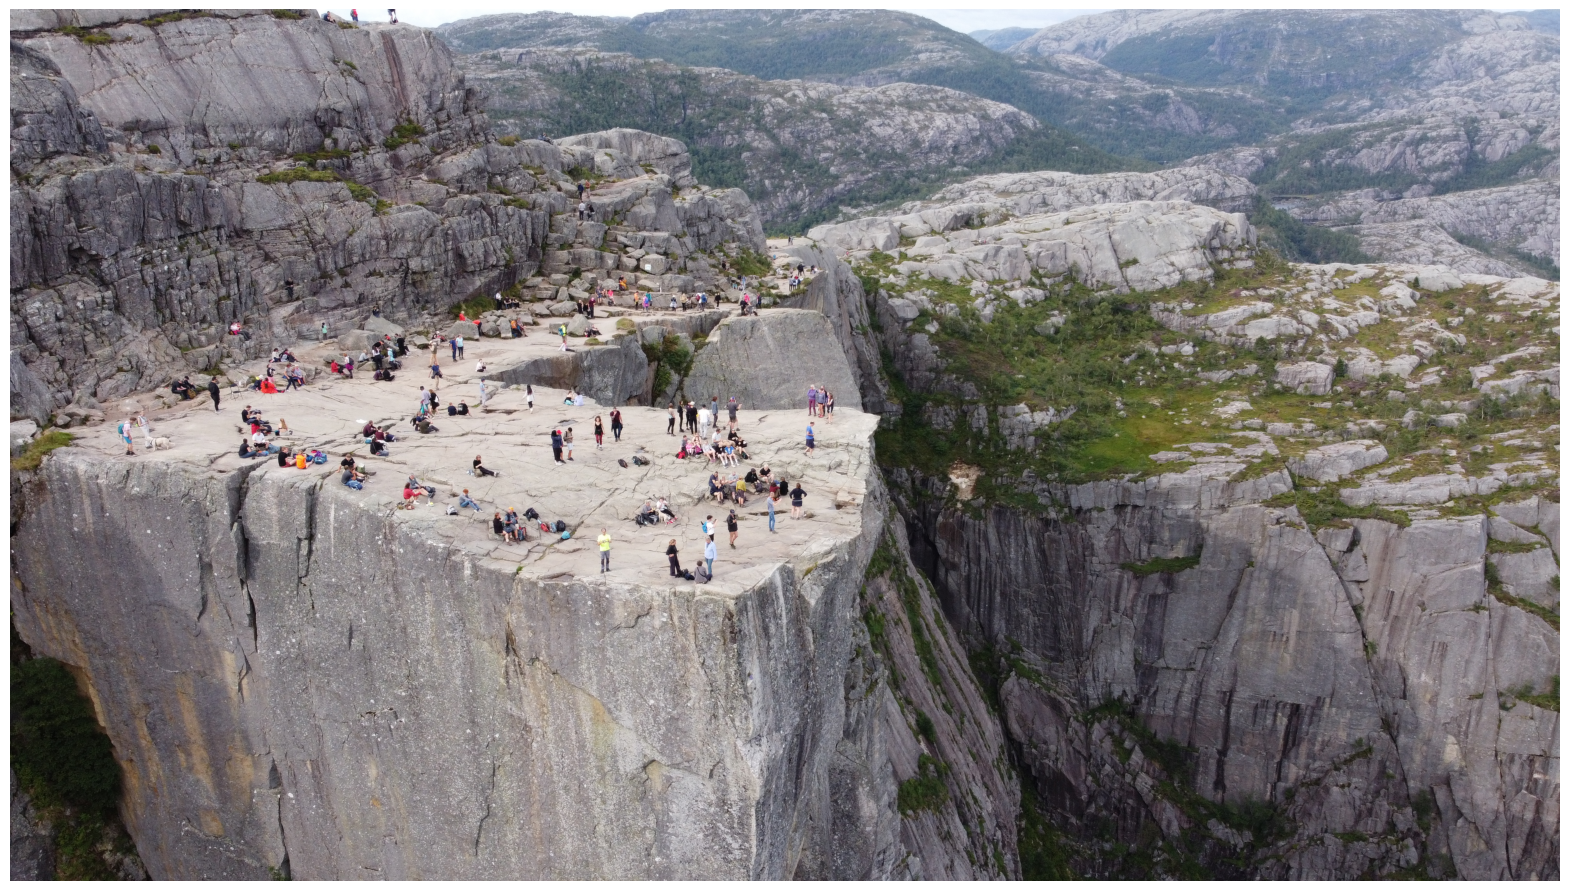

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load an image from the 'images' folder
image_path = os.path.join('images', 'drone.jpg')

# Read the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# remove the mean
image = image - np.mean(image)

colored_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
colored_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB)

# Display the image colored
plt.figure(figsize=(20, 20))
plt.imshow(colored_image)
plt.axis('off')
plt.show()

## Fourier Transform application

In [63]:
def plot_fourier_transform(image_path):
    image = cv2.imread(image_path, 0)

    # Compute the 2D Fourier Transform
    f_transform = np.fft.fft2(image)
    f_transform_shifted = np.fft.fftshift(f_transform)

    # Compute the magnitude and phase
    magnitude_spectrum = np.abs(f_transform_shifted)
    phase_spectrum = np.angle(f_transform_shifted)

    # Compute the 1D spectrum for a slice through the center of the 2D spectrum
    center = (magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2)
    slice_magnitude = magnitude_spectrum[center[0], :]
    slice_phase = phase_spectrum[center[0], :]

    # Plot the magnitude and phase as line plots
    fig, (ax_mag, ax_phase) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the magnitude spectrum slice
    ax_mag.plot(slice_magnitude)
    ax_mag.set_title('1D Slice of Magnitude Spectrum')
    ax_mag.set_yscale('log')
    ax_mag.set_xlabel('x (pixels)')
    ax_mag.set_ylabel('|G(fx, fy)|')

    # Plot the phase spectrum slice
    ax_phase.plot(slice_phase)
    ax_phase.set_title('1D Slice of Phase Spectrum')
    ax_phase.set_xlabel('x (pixels)')
    ax_phase.set_ylabel('Angle [Radians]')

    # Show the plots
    plt.tight_layout()
    plt.show()


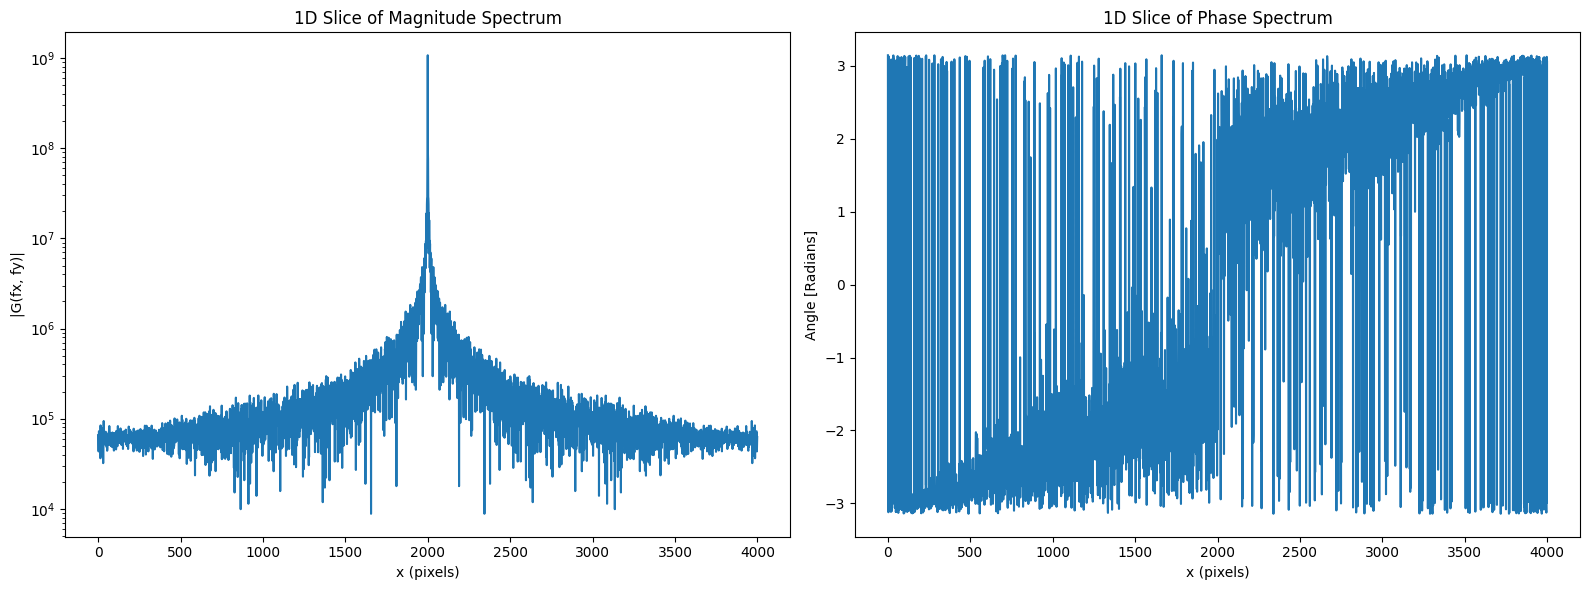

In [64]:
plot_fourier_transform(image_path)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, fftshift
from PIL import Image

def plot_magnitude_spectrum(image_path):
    # Load image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_np = np.array(image)

    #pick the middle portion of the image 64x64
    image_np = image_np[64:128, 64:128]


    # Apply Fourier Transform
    f_transform = fft2(image_np)
    #set dc component to zero
    f_transform[0, 0] = 0

    f_shifted = fftshift(f_transform)

    # Compute magnitude spectrum
    magnitude_spectrum = (np.abs(f_shifted))

    rateo = magnitude_spectrum / (magnitude_spectrum+100)

    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(image_np, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132), plt.imshow(np.log(1+magnitude_spectrum), cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

    plt.subplot(133), plt.imshow(rateo, cmap='gray')
    plt.title('Magniture Ratio'), plt.xticks([]), plt.yticks([])
    plt.show()


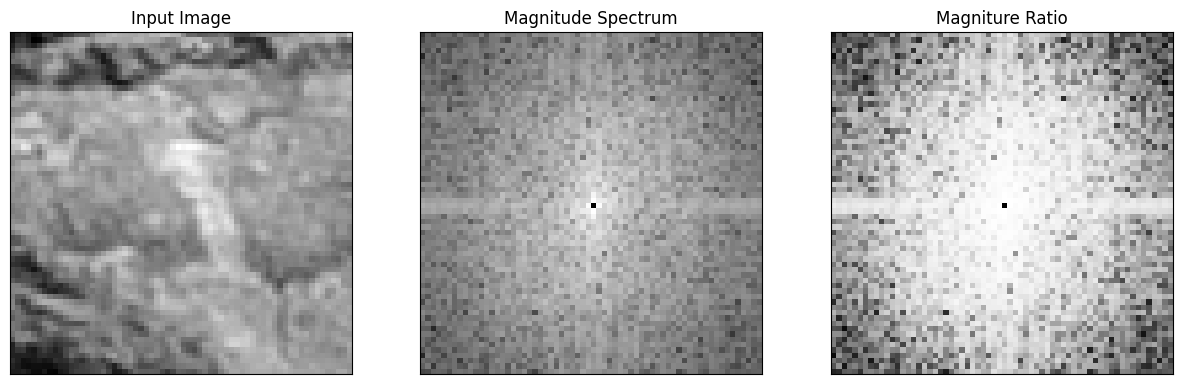

In [66]:
plot_magnitude_spectrum(image_path)

Applying on a blurred image

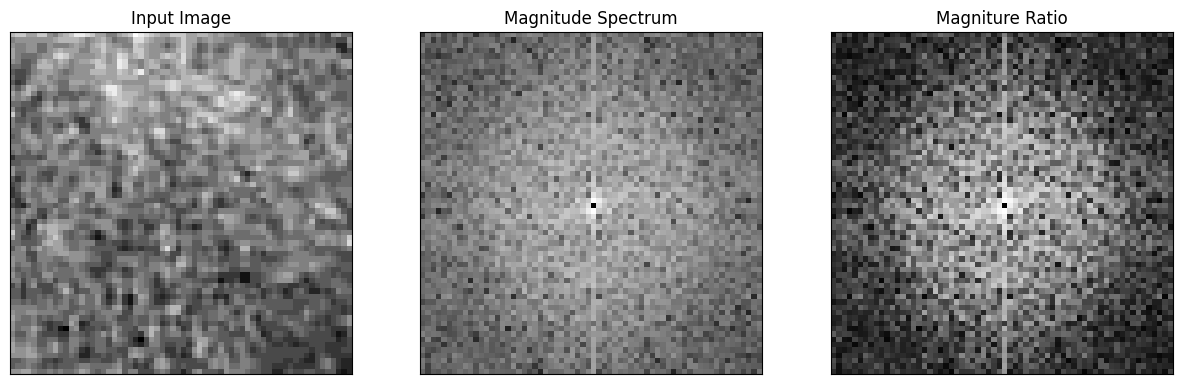

In [67]:
tunnel_path = os.path.join('images', 'tunnel.jpg')
plot_magnitude_spectrum(tunnel_path)

In [68]:
def get_blur_score_patch(patch):
    # apply dft to grad
    ftt = np.fft.fft2(patch)
    #ftt = np.fft.fftshift(ftt)

    magnitude_spectrum = np.abs(ftt)

    # set dc component to 0
    magnitude_spectrum[0, 0] = 0

    c = 100
    magnitude_spectrum = np.abs(magnitude_spectrum) / (np.abs(magnitude_spectrum) + c)

    mean = np.mean(magnitude_spectrum) 

    return mean

def get_grad_image(image):
    # Assuming the image is already in grayscale
    # Calculate the gradient in x and y direction
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5) 

    # Combine the two gradients
    return cv2.magnitude(grad_x, grad_y)

def get_blur_heatmap(image):
    # divide the image in patch of 64x64

    rows, cols = image.shape
    patch_size = 64
    
    scores = np.zeros((rows // patch_size, cols // patch_size))

    for i in range(rows // patch_size):
        for j in range(cols // patch_size):
            patch = image[i * patch_size : (i + 1) * patch_size, j * patch_size : (j + 1) * patch_size]
            score = get_blur_score_patch(patch)
            scores[i, j] = score

    return scores

def calculate_blur_score(heatmap):
    scores = heatmap.flatten()
    # keep only the scores above the median
    median = np.mean(scores)
    scores = [score for score in scores if score > median]
    return np.mean(scores)
    

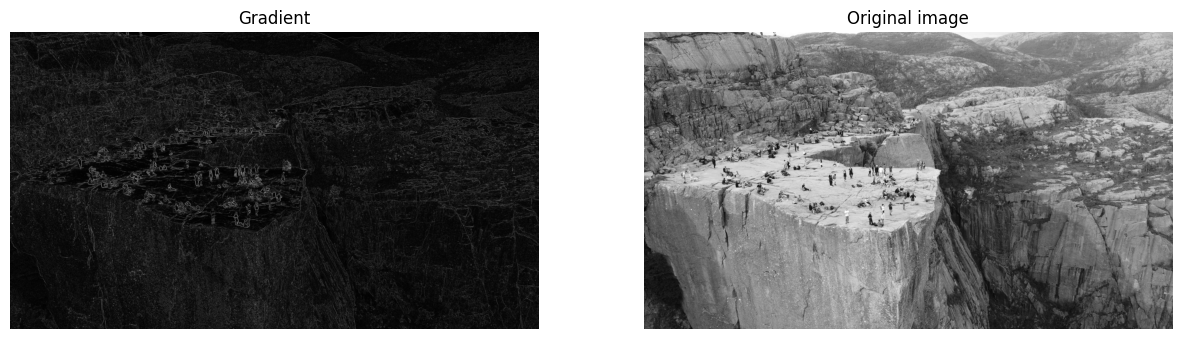

In [69]:
# Combine the two gradients
grad = get_grad_image(image)

# Display the gradient
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(grad, cmap='gray')
plt.title('Gradient')
plt.axis('off')
plt.subplot(122)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.show()

In [70]:
heatmap_grad = get_blur_heatmap(grad)
heatmap_grad_resized = cv2.resize(heatmap_grad, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

heatmap = get_blur_heatmap(image)
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

# flatten scores
scores = heatmap.flatten()
scores_grad = heatmap_grad.flatten()

# keep only the scores above the median
median = np.mean(scores)
median_grad = np.mean(scores_grad)
scores = [score for score in scores if score > median]
scores_grad = [score for score in scores_grad if score > median_grad]

# calculate the mean of the scores
blur_score = np.mean(scores)
blur_score_grad = np.mean(scores_grad)


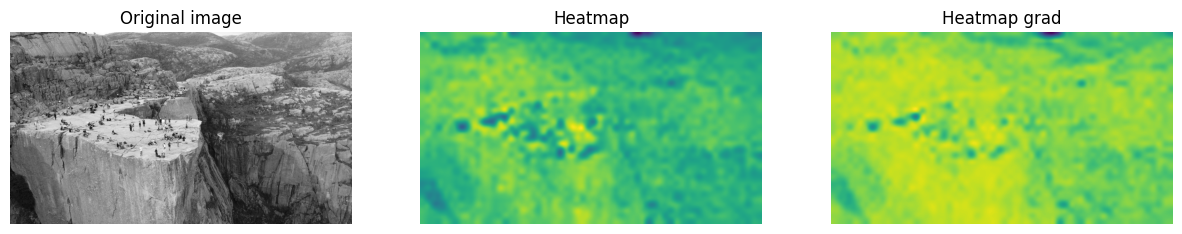

Blur score:  0.7532072426022907
Blur score grad:  0.9893037333927828


In [71]:
# plot the heatmaps
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(132)
plt.imshow(heatmap_resized,)
plt.title('Heatmap')
plt.axis('off')
plt.subplot(133)
plt.imshow(heatmap_grad_resized,)
plt.title('Heatmap grad')
plt.axis('off')
plt.show()

print('Blur score: ', blur_score)
print('Blur score grad: ', blur_score_grad)

In [72]:
from tqdm import tqdm

def get_blurred_imgs(image, blurs = [3, 5, 10, 50, 100, 200]):
    # create 5 images with different blur
    tortn = [ image ]
    tortn.extend([ cv2.blur(image, (i, i)) for i in blurs])
    return tortn, blurs

def plot_blurred_imgs(imgs, blurs):
    # plot the images
    plt.figure(figsize=(15, 8))
    for i, val in  enumerate(blurs):
        plt.subplot(2, 3, i + 1)
        plt.imshow(imgs[i + 1], cmap='gray')
        # remowe the axis
        plt.axis('off')
        plt.title(f'Blur: ({val}, {val})')

In [73]:
def process_image_blur(image_path):
    """
    Process an image for blur analysis.

    Args:
    image_path (str): Path to the image file.

    Returns:
    tuple: A tuple containing the blur scores for the original and gradient images.
    """
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Get blurred versions of the image
    blurred_images, blurs = get_blurred_imgs(image)

    # Get gradient images
    grad_blurred_images = [get_grad_image(img) for img in blurred_images]

    # Calculate blur scores
    blur_scores = [calculate_blur_score(get_blur_heatmap(blurred_image)) 
                   for blurred_image in blurred_images]

    # Calculate blur scores for gradient images
    blur_scores_grad = [calculate_blur_score(get_blur_heatmap(grad_blurred_image)) 
                        for grad_blurred_image in grad_blurred_images]

    return blur_scores, blur_scores_grad

In [74]:
image_names = ['full_car', 'tractor', 'f1', 'harbor', 'field', 'tunnel', 'preikestolen', 'pappol', 'fire', 'drone']

images_paths = [os.path.join('images', f'{image_name}.jpg') for image_name in image_names]

In [75]:
blur_scores = []
blur_scores_grad = []

for i in tqdm(range(len(images_paths)), colour='green'):
    blur_score, blur_score_grad = process_image_blur(images_paths[i])
    blur_scores.append(blur_score)
    blur_scores_grad.append(blur_score_grad)

100%|██████████| 10/10 [01:04<00:00,  6.40s/it]


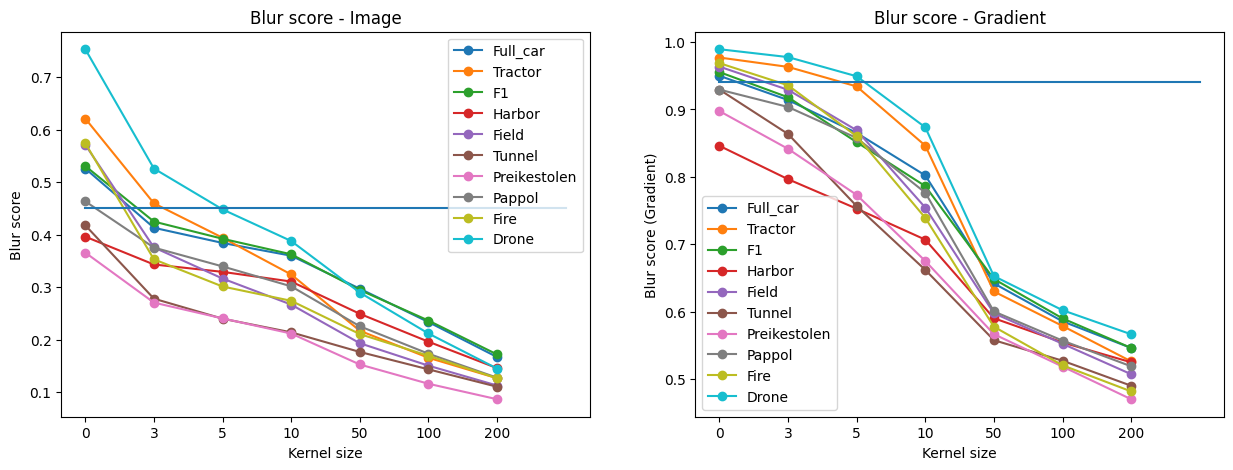

In [76]:
# plot the blur scores
plt.figure(figsize=(15, 5))
blurs = [0, 3, 5, 10, 50, 100, 200]
# First subplot
plt.subplot(121)
for i, label in enumerate(image_names):
    plt.plot(blur_scores[i], label=label.capitalize(), marker='o')  # Using the blur_scores list
plt.xlabel('Kernel size')
plt.ylabel('Blur score')
plt.legend()
plt.xticks(range(len(blur_scores[0])), blurs)
plt.plot([0, len(blurs)], [0.45, 0.45], label='Blurry threshold')
plt.title('Blur score - Image')

# Second subplot
plt.subplot(122)
for i, label in enumerate(image_names):
    plt.plot(blur_scores_grad[i], label=label.capitalize(), marker='o')  # Using the blur_scores_grad list
plt.xlabel('Kernel size')
plt.ylabel('Blur score (Gradient)')
plt.legend()
plt.xticks(range(len(blur_scores_grad[0])), blurs)
plt.plot([0, len(blurs)], [0.94, 0.94], label='Blurry threshold')
plt.title('Blur score - Gradient')

plt.show()


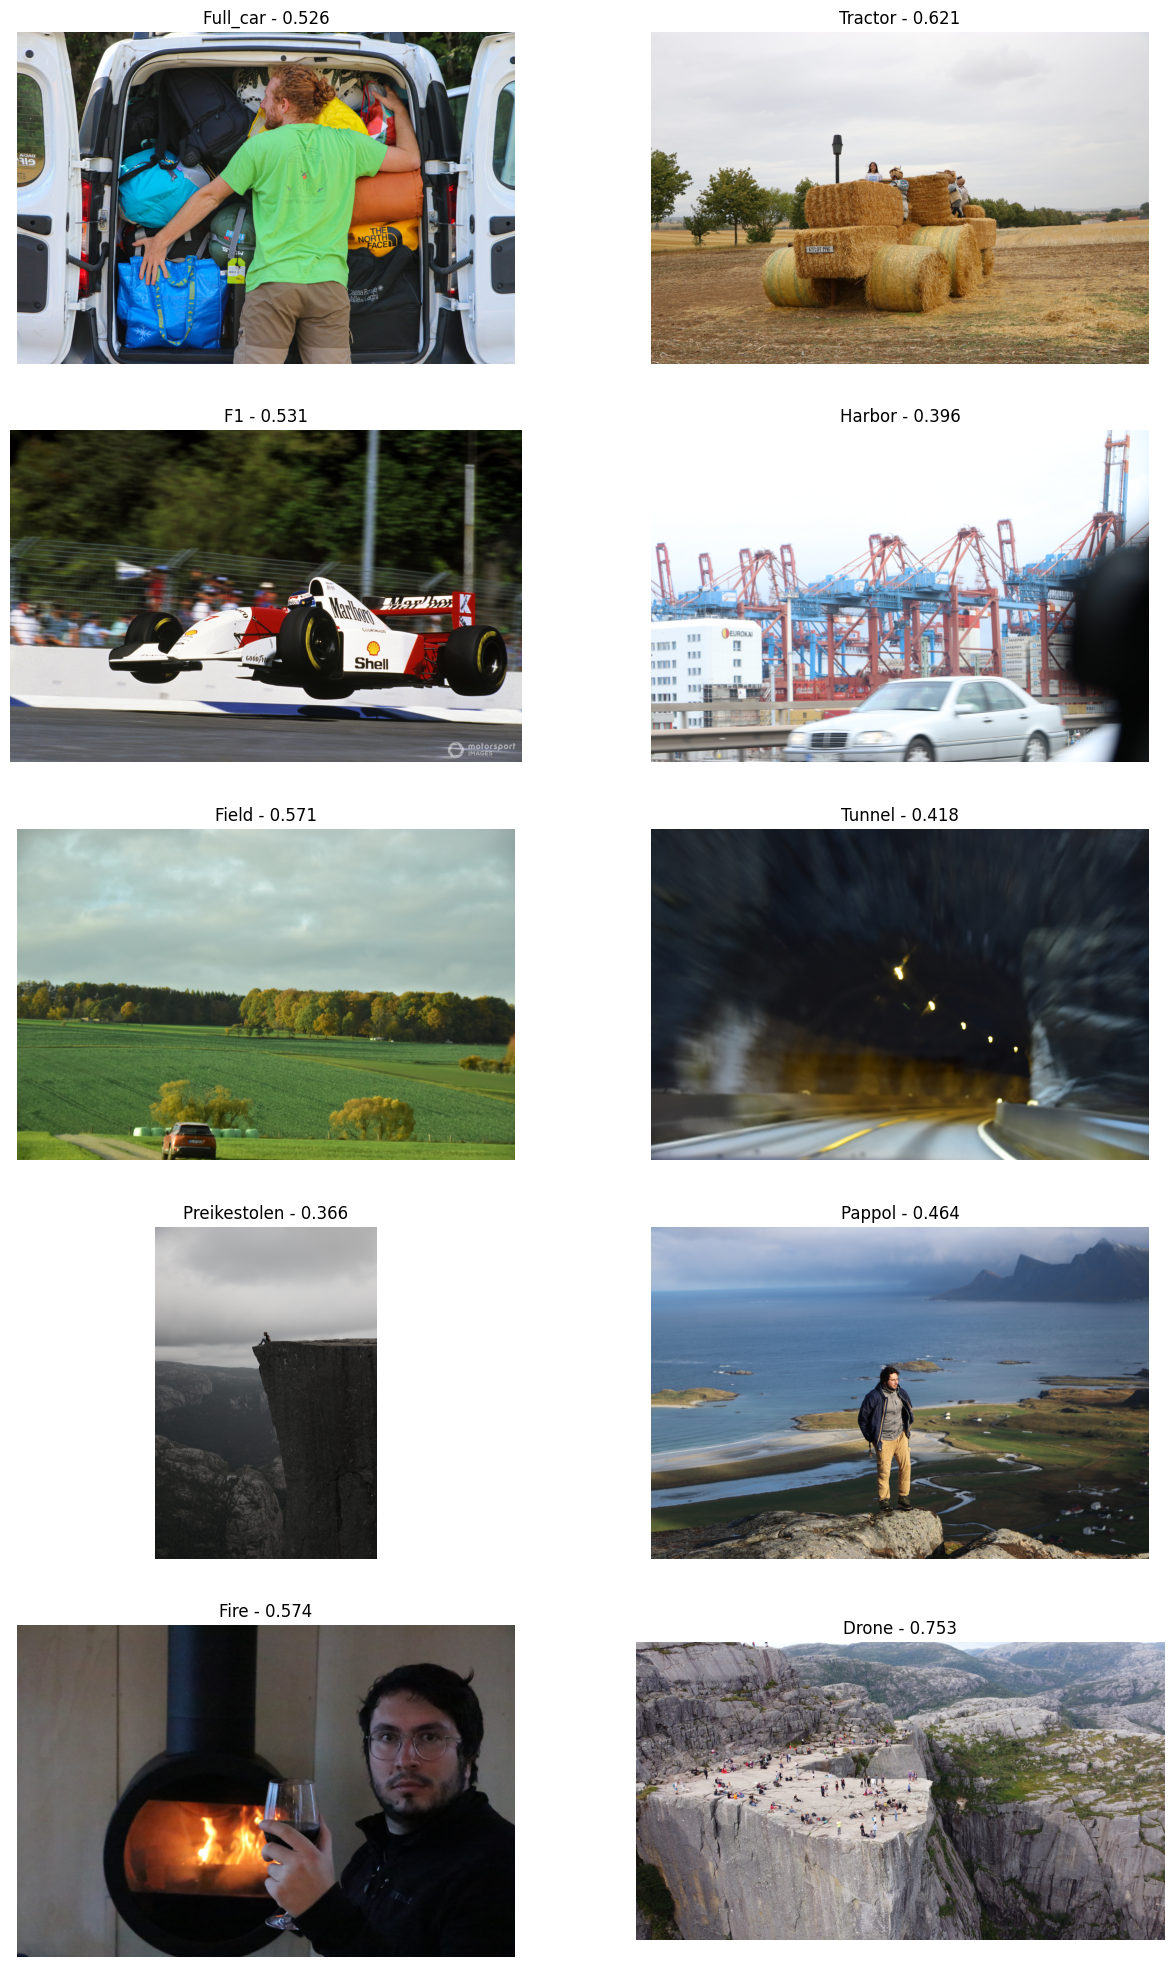

In [78]:
# Load, convert, and store images in a dictionary
images = {name: cv2.cvtColor(cv2.imread(os.path.join('images', f'{name}.jpg')), cv2.COLOR_BGR2RGB) 
          for name in image_names}

print_scores = {name: blur_scores[i] for i, name in enumerate(image_names)}

# Plot every image
plt.figure(figsize=(15, 25))
for i, (name, image) in enumerate(images.items(), 1):
    plt.subplot(5, 2, i)
    plt.imshow(image, cmap='gray')

    # Using the name directly since 'image_names' no longer has the 'full_' prefix
    plt.title(f"{name.capitalize()} - {print_scores[name][0]:.3f}")
    plt.axis('off')

plt.show()
